# Repeat result in Masich et. al using MOM025 DATA

Recent update 21 Aug 2017

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

# Topographic Stress term comparing


# No.1   $$F_{topog} = -\int_x \int_z (g*\rho*dz)*dH$$
# No.2   $$F_{topog} = -\int_x  P_{bot}*dH$$

CPU times: user 8.92 s, sys: 1.06 s, total: 9.98 s
Wall time: 10 s


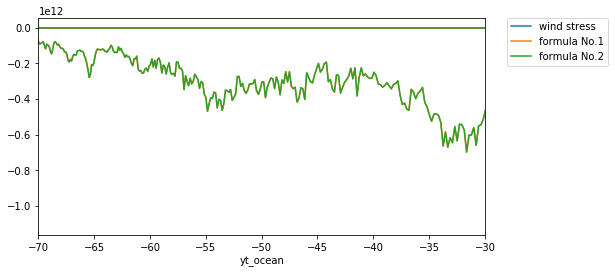

In [9]:
%%time
plt.figure(figsize=(8,4))

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
pbot = dsx2.pbot_t.mean('time')     ## p_bot

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho
dz = dsx3.dzt.mean('time')      ## dzt
g = 9.8196

temp1 = rho*g*dz
p1 = temp1.sum('st_ocean')  ## \int \rho*g*dz

ddepth=depth.diff('xt_ocean')    ## dH

dpH1 = -p1*ddepth   ## \int \int \rho*g*dz dH
dpH2 = -10000*pbot*ddepth ## \int pbot dH

taux.sum('xu_ocean').plot(label="wind stress")
dpH1.sum('xt_ocean').plot(label="formula No.1")
dpH2.sum('xt_ocean').plot(label="formula No.2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-70,-30])

(-70, -30)

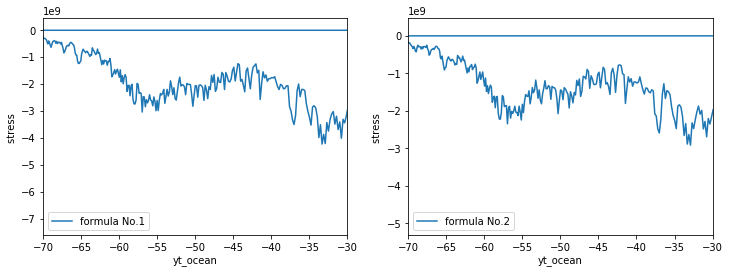

In [32]:
## Plot No. 1 and No.2 separately

plt.figure(figsize=(12,4))


plt.subplot(121)
dpH1.sum('xt_ocean').plot(label="formula No.1")
plt.legend(loc='formula No.1')
plt.ylabel('stress ')
plt.xlabel('yt_ocean')
plt.xlim([-70,-30]) 

plt.subplot(122)
dpH2.sum('xt_ocean').plot(label="formula No.2")
plt.legend(loc='formula No.2')
plt.ylabel('stress ')
plt.xlabel('yt_ocean')
plt.xlim([-70,-30]) 

# Conclusion:
### 1. results using No.1 and No.2 are almost the same
### 2. magnitudes using No.1 and no.2 are too big (10^12) compared with wind stress (10^6)
### 3. their shapes are not right.

# Form stress using anormaly and dH

# No.3   $$F_{topog} = -\int_x \int_z (g*(\rho-\rho_0)*dz)*dH$$
# No.4   $$F_{topog} = -\int_x ( P_{bot}- \int_z (g*\rho_0*dz))*dH$$

CPU times: user 9.75 s, sys: 3.78 s, total: 13.5 s
Wall time: 13.6 s


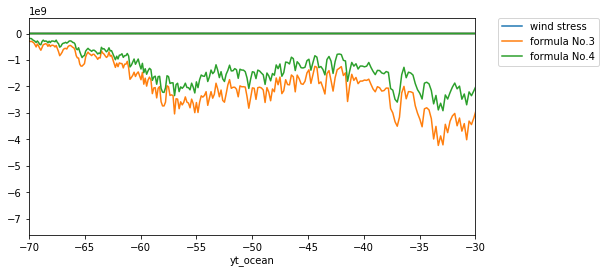

In [33]:
%%time
plt.figure(figsize=(8,4))

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
pbot = dsx2.pbot_t.mean('time')     ## p_bot

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho
dz = dsx3.dzt.mean('time')      ## dzt
g = 9.8196
rho0=1035

temp3 = (rho-rho0)*g*dz  ## (\rho-\rho0)*g*dz
p3 = temp3.sum('st_ocean')  ## \int (\rho-\rho0)*g*dz

temp4 = rho0*g*dz ## (rho0*g*dz)
p4 = 10000*pbot -temp4.sum('st_ocean')    ## \int [pbot -\int(rho0*g*dz)]

ddepth=depth.diff('xt_ocean')    ## dH

dpH3 = -p3*ddepth   ## \int \int \rho*g*dz dH
dpH4 = -p4*ddepth ## \int pbot dH

taux.sum('xu_ocean').plot(label="wind stress")
dpH3.sum('xt_ocean').plot(label="formula No.3")
dpH4.sum('xt_ocean').plot(label="formula No.4")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-70,-30])

# Conclusion:
### 1. Magnitude is still too big
### 2. there exist a small difference between No.3 and No.4
### 3. Shape still not right

# Form stress using anomaly and d$\eta$

# No. 5   $$F_{topog} = -\int_x \int_z (g*(\rho-\rho_1)*dz)*d\eta$$

### $\rho_1 =920$

# No. 6   $$F_{topog} = -\int_x \int_z (g*(\rho-\rho_0)*dz)*d\eta$$

### $\rho_0 =1035$

CPU times: user 9.83 s, sys: 6.5 s, total: 16.3 s
Wall time: 16.4 s


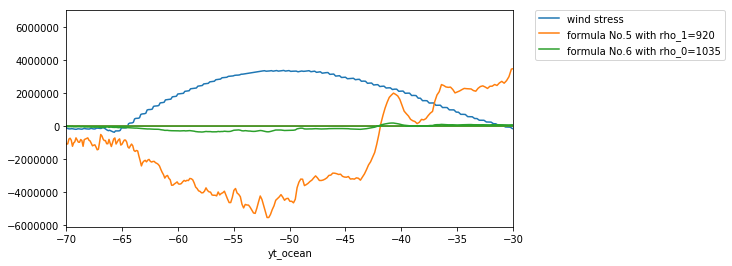

In [38]:
%%time
plt.figure(figsize=(8,4))

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
eta0 = dsx2.sea_level.mean('time') ## \eta


OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho
dz = dsx3.dzt.mean('time')      ## dzt
g = 9.8196
rho0=1035  ## \rho_0=1035
rho1=920   ## \rho_1=920

temp5 = (rho-rho1)*g*dz  ## (\rho-\rho_1)*g*dz
p5 = temp5.sum('st_ocean')  ## \int (\rho-\rho_1)*g*dz

temp6 = (rho-rho0)*g*dz  ## (\rho-\rho_0)*g*dz
p6 = temp6.sum('st_ocean')  ## \int (\rho-\rho_0)*g*dz

deta=eta0.diff('xt_ocean')    ## d\eta

dpH5 = -p5*deta   ## \int [\int (\rho-\rho_1)*g*dz ]d\eta, \rho_1 = 920
dpH6 = -p6*deta   ## \int [\int (\rho-\rho_0)*g*dz ]d\eta, \rho_0 = 1035

taux.sum('xu_ocean').plot(label="wind stress")
dpH5.sum('xt_ocean').plot(label="formula No.5 with rho_1=920")
dpH6.sum('xt_ocean').plot(label="formula No.6 with rho_0=1035")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-70,-30])

# Conclusion
### 1. using $\rho_1$=920, the magnitude is close to the wind stress, while using $\rho_0$=1035, the magnitude is too small
### 2. shape is more close to balance wind stress using d$\eta$ than using dH

# Reminder for results from last week 
## The substracted stress 

## $$F_{sub} = \int_x (-\tau^{wind}+\tau^{fric})+\rho_0\int_x \frac{d(\int_z u*v*dz*dx)}{dy}$$

## momentum flux divergence $$-\rho_0\int_x \frac{d(\int_z u*v*dz*dx)}{dy}$$

## No.5 $$F_{topog} = -\int_x \int_z (g*(\rho-\rho_1)*dz)*d\eta$$

### $\rho_1 =920$

CPU times: user 18.1 s, sys: 7.37 s, total: 25.5 s
Wall time: 25.6 s


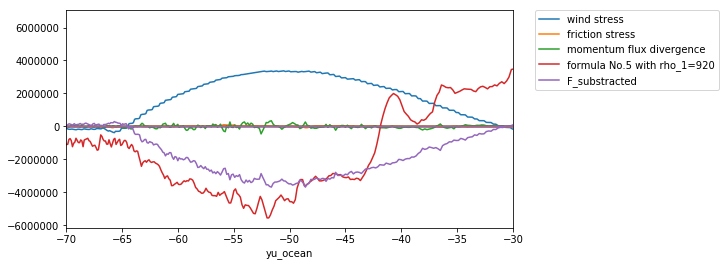

In [57]:
%%time
plt.figure(figsize=(8,4))

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H
dyu = dsx1.dyu
dxu = dsx1.dxu

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_wind
tau_fric= dxu*dsx2.bmf_u.mean('time') ## tau_fric
eta0 = dsx2.sea_level.mean('time') ## \eta


OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho
dz = dsx3.dzt.mean('time')      ## dzt
u = dsx3.u.mean('time')  ## u
v = dsx3.v.mean('time')  ## v

g = 9.8196
rho1=920   ## \rho_1=920
rho0=1035  ## \rho_0=1035

uv=u*v                                ## u*v
dzu = dsx3.st_ocean.diff('st_ocean')  ## dzu
uvdz = uv*dzu                         ## u*v*dzu
uvsum = uvdz.sum('st_ocean')*dxu/dyu  ## \int u*v*dzu*dxu/dyu
momfd = -rho0*uvsum.diff('yu_ocean')  ## -\rho_0* d(\int u*v*dzu*dxu/dyu) 

fsub = -taux.isel(yu_ocean=np.arange(1,1080))+tau_fric.isel(yu_ocean=np.arange(1,1080))-momfd 
## \int[-tau_wind+ tau_fric + \rho_0* d(\int u*v*dzu*dxu/dyu) ]
## delete the frist point on yu_ocean axis because momfd use diff(yu_ocean) which has one missing point

temp = (rho-rho1)*g*dz  ## (\rho-\rho_1)*g*dz
p = temp.sum('st_ocean')  ## \int (\rho-\rho_1)*g*dz
deta=eta0.diff('xt_ocean')    ## d\eta
dpH = -p*deta   ## \int [\int (\rho-\rho_1)*g*dz ]d\eta, \rho_1 = 920


taux.sum('xu_ocean').plot(label="wind stress")
tau_fric.sum('xu_ocean').plot(label="friction stress")
momfd.sum('xu_ocean').plot(label="momentum flux divergence")
dpH.sum('xt_ocean').plot(label="formula No.5 with rho_1=920")
fsub.sum('xu_ocean').plot(label="F_substracted")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-70,-30])

# Conclusion
### 1. The F_substracted (purple) from wind, friction (smallest), momtum flux (small)
### 2. The fluctuation in F_substrated and F_top using No.5 has similar shape and sign. This might prove our method could predict the F_top somehow but still not correct???


## some extra discussion

# No.7     $$\int_x g*\rho_0*H*dH$$

CPU times: user 531 ms, sys: 9 ms, total: 540 ms
Wall time: 539 ms


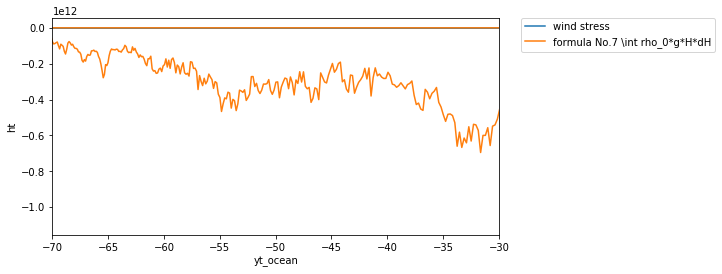

In [62]:
%%time
plt.figure(figsize=(8,4))

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H

g = 9.8196
rho0=1035  ## \rho_0=1035

ddepth=depth.diff('xt_ocean')    ## dH

dpH7 = -rho0*depth*g*ddepth  ## \rho_0*g*H*dH

taux.sum('xu_ocean').plot(label="wind stress")
dpH7.sum('xt_ocean').plot(label="formula No.7 \int rho_0*g*H*dH")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-70,-30])

# Conclusion
## 1. H dH is not equal to 0 and it is very large, so the problem can be caused by large fluctuations in H
## 2. How to fix this problem???